In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetdos/data2.csv
/kaggle/input/datasetdos/data3.csv
/kaggle/input/datasetdos/data1.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data1=pd.read_csv('/kaggle/input/datasetdos/data1.csv')
data2=pd.read_csv('/kaggle/input/datasetdos/data2.csv')
data3=pd.read_csv('/kaggle/input/datasetdos/data3.csv')

train_data=pd.concat([data1,data2,data3]).reset_index(drop=True)

train_data = train_data.drop(columns='Unnamed: 0')

train_data["Label"] = train_data["Label"].replace(["Benign","Anomaly"],[0,1])
for label, index in zip(['Benign', 'Anomaly'], [0, 1]):
    print(f"{label}: {index}")

Benign: 0
Anomaly: 1


In [ ]:
print(train_data["Label"].value_counts())

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = train_data.drop("Label", axis=1)
y = train_data["Label"]

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

print(Counter(y))

Label
0    1567950
1    1000448
Name: count, dtype: int64
Counter({0: 1000448, 1: 1000448})


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import pandas as pd

def optimize_xgboost_gpu(X, y, cv=5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 300],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.2],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }

    xgb = XGBClassifier(
        random_state=42,
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    )

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results[['params', 'mean_test_score', 'std_test_score']]
    cv_results = cv_results.sort_values('mean_test_score', ascending=False).head()

    return grid_search.best_estimator_, cv_results


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
best_model, cv_results = optimize_xgboost_gpu(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:54:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:54:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:54:24] WARNING: /workspace/src/common/error_ms

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
Best Cross-Validation Score: 0.9998850514574334


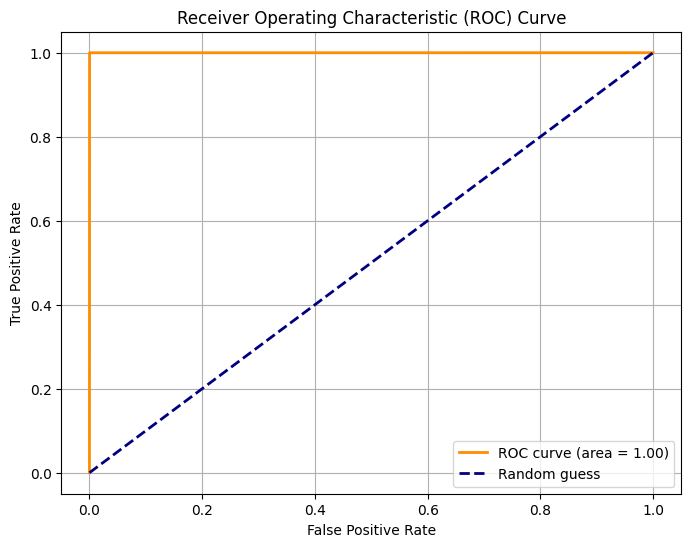

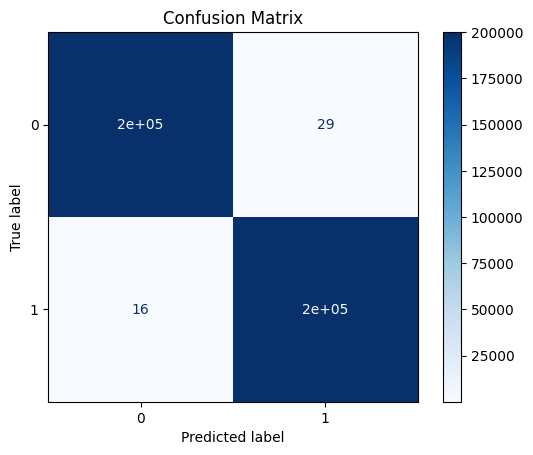

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200069
           1       1.00      1.00      1.00    200111

    accuracy                           1.00    400180
   macro avg       1.00      1.00      1.00    400180
weighted avg       1.00      1.00      1.00    400180



In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


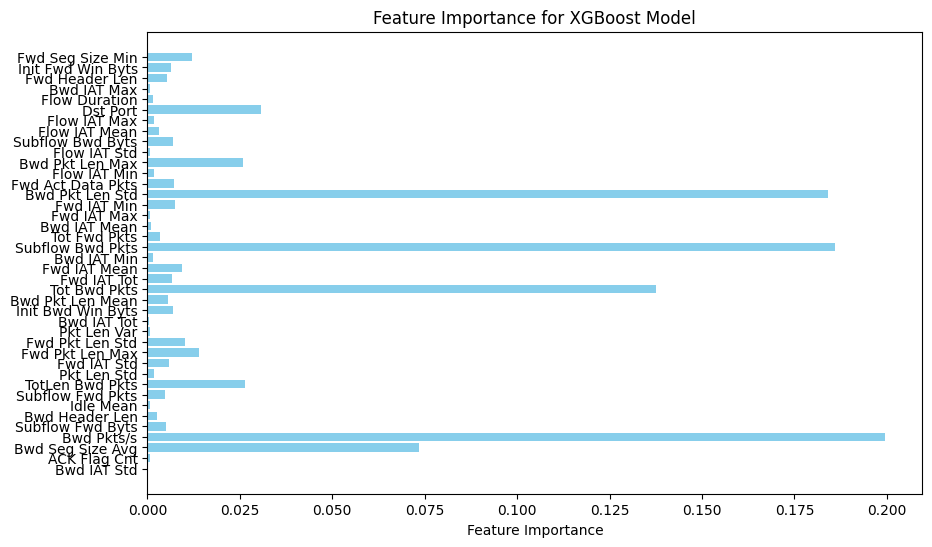

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, best_model.feature_importances_, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for XGBoost Model')
plt.show()


In [ ]:
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"Eğitim Doğruluğu: {train_accuracy:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")


Eğitim Doğruluğu: 0.9999
Test Doğruluğu: 0.9999


In [ ]:
print("Cross-Validation En Yüksek Skoru:", cv_results['mean_test_score'].max())

Cross-Validation En Yüksek Skoru: 0.9998850514574334


In [ ]:
from sklearn.utils import resample

boot_scores = []
for i in range(100):
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    best_model.fit(X_boot, y_boot)
    boot_scores.append(best_model.score(X_test, y_test))

print(f"Bootstrap Ortalama Skoru: {np.mean(boot_scores):.4f}")
print(f"Bootstrap Standart Sapması: {np.std(boot_scores):.4f}")


Bootstrap Ortalama Skoru: 0.9999
Bootstrap Standart Sapması: 0.0000


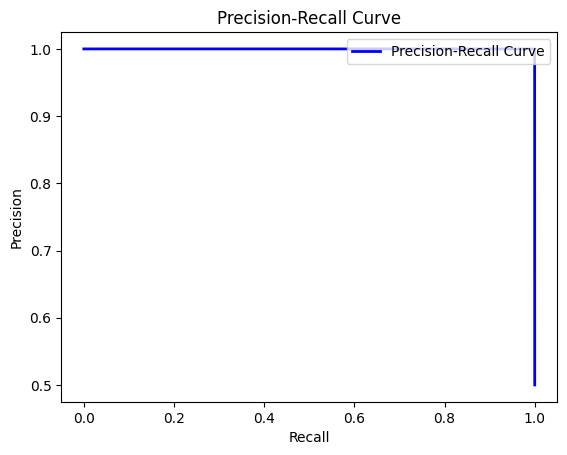

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, lw=2, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In [ ]:
best_model.save_model("xgboost_model.json")

In [ ]:
import joblib
joblib.dump(best_model, "xgboost_model.pkl")

['xgboost_model.pkl']

In [ ]:
import numpy as np

X_train_noisy = X_train + np.random.normal(0, 0.1, X_train.shape)

y_pred_noisy = best_model.predict(X_test)
print(f"Gürültülü Veri Üzerindeki Doğruluk: {accuracy_score(y_test, y_pred_noisy):.4f}")


Gürültülü Veri Üzerindeki Doğruluk: 0.9997


In [ ]:
X_train_augmented = X_train * np.random.uniform(0.8, 1.2, size=X_train.shape)

y_pred_augmented = best_model.predict(X_test)
print(f"Veri Değiştirme ile Test Sonucu: {accuracy_score(y_test, y_pred_augmented):.4f}")


Veri Değiştirme ile Test Sonucu: 0.9997
